In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [2]:
class GPSMemorySCM:
    def __init__(self,random_seed = None):
      self.random_seed = random_seed
      self.u_x = stats.truncnorm(0, np.infty, scale=5)
      self.u_y = stats.norm(scale=2)
      self.u_z = stats.norm(scale=2)
      self.u = stats.truncnorm(0, np.infty, scale=4)

    def sample(self, sample_size=100, treatment_value=None):
      """Samples from the SCM"""
      if self.random_seed:
          np.random.seed(self.random_seed)
      u_x = self.u_x.rvs(sample_size)
      u_y = self.u_y.rvs(sample_size)
      u_z = self.u_z.rvs(sample_size)
      u = self.u.rvs(sample_size)
      if treatment_value:
          gps = np.array([treatment_value]*sample_size)
      else:
          gps = u_x + 0.7*u
      hippocampus = -0.6*gps + 0.25*u_z
      memory = 0.7*hippocampus + 0.25*u + 0.2*u_y
      return gps, hippocampus, memory,u

    def intervene(self, treatment_value, sample_size=100):
        """Intervenes on the SCM"""
        return self.sample(treatment_value=treatment_value, sample_size=sample_size)

### Instantiating our model and generating some data

In [3]:
scm = GPSMemorySCM()
gps_obs, hippocampus_obs, memory_obs,u = scm.sample(600)

### We will use a range of treatments from 1 to 20 units of GPS usage:

In [4]:
treatments = []
experiment_results = []
# Sample over a range of treatments
for treatment in np.arange(1, 21):
    gps_hours, hippocampus, memory,u_temp = scm.intervene(treatment_value=treatment, sample_size=30)
    experiment_results.append(memory)
    treatments.append(gps_hours)

For each treatment value, we sample 30 observations. We store treatment values and outcome values in the treatments and experiment_results lists respectively


Visualizing the generated samples

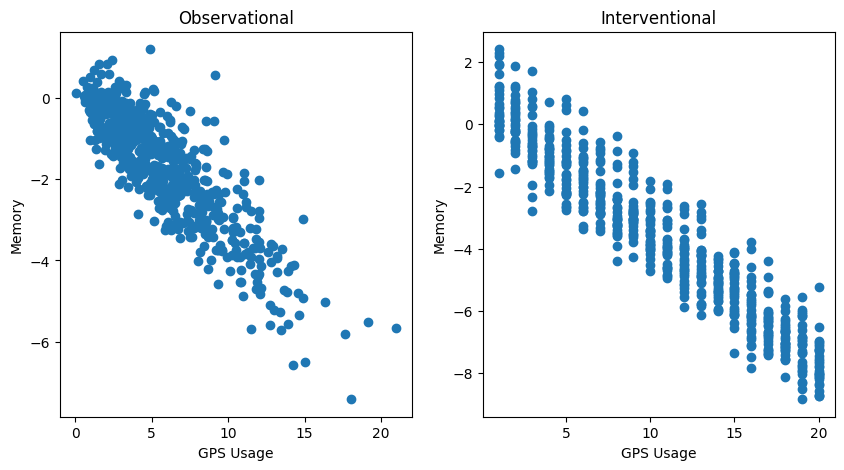

In [5]:
fig = plt.figure(figsize = (10,5))
ax = fig.add_subplot(121)
ax.scatter(gps_obs, memory_obs)
ax.set_xlabel('GPS Usage')
ax.set_ylabel('Memory')
ax.set_title('Observational')

ax = fig.add_subplot(122)
ax.scatter(treatments, experiment_results)
ax.set_xlabel('GPS Usage')
ax.set_ylabel('Memory')
ax.set_title('Interventional')
plt.show()

In [6]:
treatment

20

### Fitting regression model on both sets

In [7]:
lr_naive = LinearRegression()
lr_naive.fit(
    X=gps_obs.reshape(-1, 1),
    y=memory_obs
)

treatments_unpack = np.array(treatments).flatten()
results_unpack = np.array(experiment_results).flatten()
lr_experiment = LinearRegression()
lr_experiment.fit(
    X=treatments_unpack.reshape(-1, 1),
    y=results_unpack
)

LinearRegression()

## Predicting on testing set

In [8]:
X_test = np.arange(1, 21).reshape(-1, 1)
preds_naive = lr_naive.predict(X_test)
preds_experiment = lr_experiment.predict(X_test)

### Plotting it over the scattered data

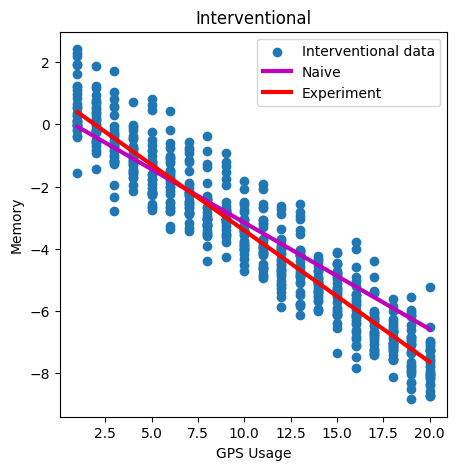

In [9]:
fig = plt.figure(figsize = (5,5))

ax = fig.add_subplot(111)
ax.scatter(treatments, experiment_results,label = 'Interventional data')
ax.plot(X_test, preds_naive, color = 'm',lw = 3,label = 'Naive')
ax.plot(X_test, preds_experiment, color = 'r',lw = 3,label = 'Experiment')
ax.set_xlabel('GPS Usage')
ax.set_ylabel('Memory')
ax.set_title('Interventional')
plt.legend()
plt.show()

Looking at the slope of both models

In [10]:
print(f'Naive model:\n{lr_naive.coef_}\n')
print(f'Experimental model:\n{lr_experiment.coef_}')

Naive model:
[-0.34262001]

Experimental model:
[-0.42264468]


Let’s figure out how to get a valid causal coefficient from observational data using the front-door criterion in three simple steps.

It turns out that when we’re lucky enough that our model of interest is linear and the front-door criterion can be applied, we can compute the valid estimate of the causal effect of X on Y in three simple steps:

1. Fit a model: $Z = f(X)$
2. Fit a model: $Y = f(Z,X)$
3. Multiply the coefficients from model 1 and model 2

  

### Coding it

1. First, we train the model to regress Z on X (Z ~ X). Note that we only use observational data to fit this (and the following) model:


In [11]:
lr_zx = LinearRegression()
lr_zx.fit(
    X=gps_obs.reshape(-1, 1),
    y=hippocampus_obs
)

LinearRegression()

2. Next, let’s train the model to regress Y on X and Z. Note that in both cases, we follow the same logic that we followed in the continuous case described previously:

In [12]:
lr_yxz = LinearRegression()
lr_yxz.fit(
    X=np.array([gps_obs, hippocampus_obs]).T,
    y=memory_obs
)

LinearRegression()

3. Finally, let’s multiply the coefficients for both models:

In [13]:
lr_zx.coef_

array([-0.60553261])

In [14]:
lr_yxz.coef_

array([0.06422899, 0.67188619])

In [15]:
lr_zx.coef_ * lr_yxz.coef_[1]

array([-0.406849])

This is pretty close to the experimental model!

1. Values estimated from experiments and values estimated from observational data may differ in finite sample regimes, and that’s utterly natural.

2. The larger the sample size, the smaller the discrepancy between them we should expect on average.


In our case, the true causal effect of GPS usage on spatial memory will be -0.6 * 0.7 = -0.42. The coefficients (-0.6 and 0.7) can be read from the definition of our SCM.

### Assuming we can use the backdoor criterion

In [16]:
print(u.shape)

(600,)


In [17]:
X = pd.DataFrame(np.vstack([gps_obs, u]).T, columns=['gps', 'U'])
X = sm.add_constant(X, prepend=True)
model = sm.OLS(memory_obs,X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.851
Model:                            OLS   Adj. R-squared:                  0.850
Method:                 Least Squares   F-statistic:                     1702.
Date:                Mon, 03 Jun 2024   Prob (F-statistic):          2.34e-247
Time:                        15:42:42   Log-Likelihood:                -476.79
No. Observations:                 600   AIC:                             959.6
Df Residuals:                     597   BIC:                             972.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0301      0.045      0.668      0.5

In [18]:
results.params['gps']

-0.42012769418187157

### Quantifying errors:

In [19]:
true = -0.42

In [20]:
## Error in Naive model
e = abs((true - lr_naive.coef_[0])/true)*100
print(f'Error in Naive model: {e:0.2f}%')

Error in Naive model: 18.42%


In [21]:
## Error in Experimental/interventional model
e = abs((true - lr_experiment.coef_[0])/true)*100
print(f'Error in experimental model: {e:0.2f}%')

Error in experimental model: 0.63%


In [22]:
# Error in Front door method
e = abs((true - (lr_zx.coef_[0] * lr_yxz.coef_[1]))/true)*100
print(f'Error in Front door method: {e:0.2f}%')

Error in Front door method: 3.13%


In [23]:
# Error in Back door method
e = abs((true - results.params['gps'])/true)*100
print(f'Error in Back door method: {e:0.2f}%')

Error in Back door method: 0.03%


 Starting from 20% ish error in naive model, imagine that you can improve the conversion rate of a marketing campaign by this much percentage for your client